In [2]:
#Load necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from numpy.fft import fft, ifft
from IPython.display import Audio
from scipy import signal
from ipykernel import kernelapp as app

In [3]:
FRAME_SIZE = 1024

In [4]:
# An algorithm to detect whether a frame is voiced or not
def voice_decider(frame):
    isVoiced = 0
    energy = 0
    
    for i in range(len(frame)):
        energy = energy + frame[i]*frame[i]

    if(energy>990000000):
        isVoiced = 1
        
    return isVoiced

In [5]:
# Load contaminated signal by crowd noise
Fs, data = read('fan_noise1.wav')
numFrames = int(len(data) / 1024)
output = np.zeros(len(data))
crowd_filter = np.zeros(FRAME_SIZE)
window_num = 0
noise_spectrum = np.zeros(FRAME_SIZE)

In [6]:
for i in range(numFrames):
    frame = data[i * FRAME_SIZE : ((i+1) * FRAME_SIZE)]
    
    if(voice_decider(frame.astype(float)) == 0):
        curFft = np.abs(np.fft.fft(frame))
        # For unvoiced frames, collect statistics about noise spectrum
        noise_spectrum = (noise_spectrum * window_num + curFft)/(window_num + 1)
        window_num = window_num + 1
        
        # Attenuate noise
        output[i * FRAME_SIZE : ((i+1) * FRAME_SIZE)] = frame/10000
        continue
    
    DFT = np.fft.fft(frame)
    DFT1 = DFT
    
    for t in range(FRAME_SIZE):
        # Spectrum subtraction
        if (np.abs(DFT[t]) != 0):
            DFT[t] = (np.abs(DFT[t]) - noise_spectrum[t])*DFT[t]/np.abs(DFT[t])

        # Calculate power spectrum
        s = np.abs(DFT[t])*np.abs(DFT[t])
        n = noise_spectrum[t]*noise_spectrum[t]
        
        # Carry out Wiener filter
        if(s+n != 0):
            crowd_filter[t] = (s/(s+n))**2
        else:
            crowd_filter[t] = 0

    # Add back to the frame
    DFT1 = np.multiply(DFT, crowd_filter)
    
    output[i * FRAME_SIZE : ((i+1) * FRAME_SIZE)] = np.fft.ifft(DFT1)

/Users/lihongyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part


In [7]:
# Play out the original audio
Audio(data, rate=Fs)

In [8]:
# Play out the processed audio
Audio(output, rate=Fs)

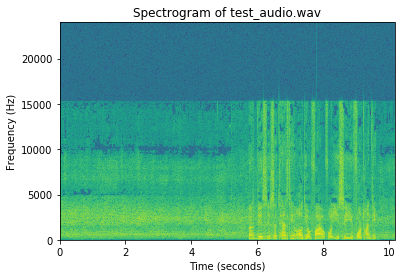

In [8]:
# Plot the spectrogram for original signal
Pxx, freqs, bins, im = plt.specgram(data, NFFT=1024, Fs=48000, noverlap=512)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of test_audio.wav')
plt.show()

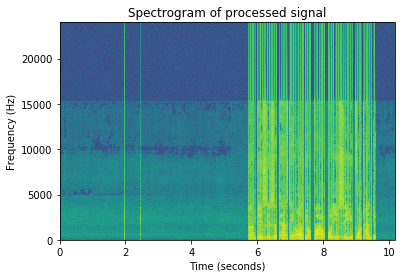

In [9]:
# Plot the spectrogram for processed signal
Pxx, freqs, bins, im = plt.specgram(output, NFFT=1024, Fs=48000, noverlap=512)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of processed signal')
plt.show()